<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="./fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

---
## XGBoost

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

import display_functions
import helper_functions
import model_functions

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = helper_functions.load_feather_as_df(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
60,17518,0,0.352941,0.341176,0.298039,0.130952,0.155556,0.352941,36.951897,-0.945561,...,-0.029703,0.023529,18.780698,0.050593,-0.016949,2.176471,0.340563,0.966664,1.144733,1.184207
162,17565,0,0.164706,0.207843,0.203922,0.484848,0.207547,0.207843,21.155821,-4.862577,...,0.255812,0.060000,18.769584,0.125174,0.115789,1.745098,0.198389,1.261897,1.019226,0.807688
280,17804,0,0.254902,0.290196,0.262745,0.370370,0.121622,0.290196,30.464077,-5.235969,...,0.125000,0.057143,18.765220,0.114026,0.064748,2.882353,0.280711,1.138457,1.104473,0.970146
121,17538,1,0.372549,0.392157,0.341176,0.230769,0.130000,0.392157,41.587777,-4.587569,...,0.046296,0.047120,18.764608,0.094990,0.025641,3.745098,0.384307,1.052629,1.149422,1.091951
27,1,1,0.396078,0.443137,0.407843,0.375000,0.106195,0.443137,46.413583,-6.420138,...,0.109091,0.048724,18.759306,0.097323,0.056075,3.764706,0.430584,1.118809,1.086536,0.971151


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


### Hold-out externo

In [8]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hold-out interno

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(362, 26)
(362,)
(91, 26)
(91,)
(114, 26)
(114,)


#### Nota: Para este modelo se hace un hold-out externo/interno para poder aplicar un early stopping.

### XGBClassifier

In [11]:
xgb_base = XGBClassifier(
    objective='binary:logistic' if len(np.unique(y)) == 2 else 'multi:softprob',
    num_class=len(np.unique(y)), 
    eval_metric="mlogloss" if len(np.unique(y_train)) > 2 else "logloss", # multiclase or clasificación binaria
    tree_method="hist",        # Funciona muy bien para datasets medianos/grandes típicos en EO. Rápido y estable, especialmente en MacOS
    subsample=0.8,              # reduce overfitting
    colsample_bytree=0.8,       # importante con índices correlados
    random_state=42,
    n_jobs=1,                   # usar solo un hilo evita segfault en MacOs
    nthread=1,                  # evitar segfaults
    use_label_encoder=False,
    verbosity=0 # 0 = silencioso; 1 = información básica; 2 = más detallado
)

Grid de hiperparámetros

In [12]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 8, 10], # controla mezcla espectral vs sobreajuste
    'learning_rate': [0.05, 0.1], # 0.05 bajo → mejor generalización
    "min_child_weight": [1, 5, 10], # evita splits con ruido radiométrico  
    "gamma": [0, 0.1, 0.3], # penaliza divisiones poco informativas 
    "reg_lambda": [1, 5, 10], # elimina índices irrelevantes  
    "reg_alpha": [0, 0.5, 1], # suaviza pesos de bandas correladas   
}

GridSearchCV 

In [13]:
cv_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_weighted',  # o "balanced_accuracy"
    n_jobs=1,               # evita paralelismo problemático en McOS
    verbose=2,
    refit=True,
    error_score='raise',
    pre_dispatch='1*n_jobs'
)

Para clases no balanceadas

In [14]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [15]:
cv_xgb.fit(X_train, y_train, sample_weight=sample_weight)
print("Mejores parámetros:", cv_xgb.best_params_)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total t

In [16]:
xgboost_best_model = cv_xgb.best_estimator_

Entrenar modelo final con early stopping

![XGBoost Early Stopping](fig/xgboost_early_stopping.png)

In [17]:
xgboost_final_model = XGBClassifier(
    **cv_xgb.best_params_,
    use_label_encoder=False,
    eval_metric="mlogloss" if len(np.unique(y_train)) > 2 else "logloss", # multiclase or clasificación binaria
    early_stopping_rounds=20,
    random_state=42
)

In [18]:
xgboost_final_model.fit(
    X_train, y_train,
    sample_weight=sample_weight,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mlogloss:1.02036
[1]	validation_0-mlogloss:0.94821
[2]	validation_0-mlogloss:0.88536
[3]	validation_0-mlogloss:0.82950
[4]	validation_0-mlogloss:0.78170
[5]	validation_0-mlogloss:0.73757
[6]	validation_0-mlogloss:0.69964
[7]	validation_0-mlogloss:0.66569
[8]	validation_0-mlogloss:0.63401
[9]	validation_0-mlogloss:0.60641
[10]	validation_0-mlogloss:0.58169
[11]	validation_0-mlogloss:0.55607
[12]	validation_0-mlogloss:0.53569
[13]	validation_0-mlogloss:0.51805
[14]	validation_0-mlogloss:0.50095
[15]	validation_0-mlogloss:0.48585
[16]	validation_0-mlogloss:0.47238
[17]	validation_0-mlogloss:0.45916
[18]	validation_0-mlogloss:0.44673
[19]	validation_0-mlogloss:0.43640
[20]	validation_0-mlogloss:0.42830
[21]	validation_0-mlogloss:0.41806
[22]	validation_0-mlogloss:0.41138
[23]	validation_0-mlogloss:0.40479
[24]	validation_0-mlogloss:0.39755
[25]	validation_0-mlogloss:0.39107
[26]	validation_0-mlogloss:0.38471
[27]	validation_0-mlogloss:0.37912
[28]	validation_0-mlogloss:0.3

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mlogloss'


Evaluación final en test

In [20]:
y_pred = xgboost_final_model.predict(X_test)

Métricas

In [21]:
mse,rmse,r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.12280701754385964
RMSE:  0.3504383220252312
R²:    0.6649874055415617
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        73
           1       0.78      0.82      0.80        34
           2       0.57      0.57      0.57         7

    accuracy                           0.88       114
   macro avg       0.77      0.78      0.77       114
weighted avg       0.88      0.88      0.88       114

[[68  5  0]
 [ 3 28  3]
 [ 0  3  4]]


Matriz de confusión

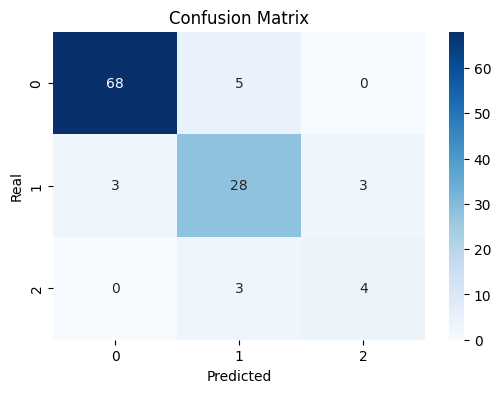

In [22]:
display_functions.plot_confusion_matrix(conf_matrix)

### Ploteamos la curva ROC

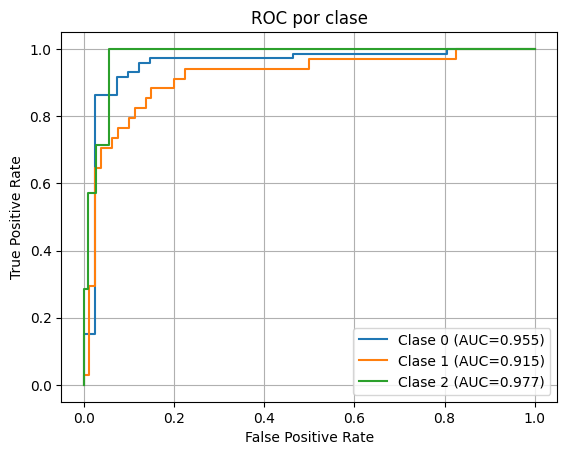

In [23]:
display_functions.plot_roc_curve(xgboost_best_model,X_test, y_test)

## Save XGBoost best model

In [24]:
xgboost_best_model_selected_path = os.path.join(project_models, "xgboost_best_model.pkl")

model_functions.save_model(xgboost_final_model, xgboost_best_model_selected_path)